In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier

# Baseline Models

## Quick data preparation
* Drop unique indexing columns (geometry and indexing).
* Drop accident_severity as it is just a slightly modified version of our target variable (casualty_severity)
* OHE columns and seperate X and y.

In [2]:
train = pd.read_csv('training_data.csv', low_memory = False)

y_train = train.casualty_severity
X_train = train.drop(['casualty_severity','accident_severity', 'geometry', 'accident_index'], axis=1)

severity_dict = {'Slight': 0, 'Serious': 1, 'Fatal': 1}
y_train.replace(severity_dict, inplace=True)

X_train = pd.get_dummies(X_train, prefix_sep='_')

## Dummy Classifier
Let's create a "dummy classifier" that makes predictions without any input features. This will be our simple baseline to compare our more complex classifiers.

Here, we are predicting everything to have the 'majority' label - 0 (i.e. not a serious or fatal incident). Because the classes are imbalanced (the majority of data has a true label of 0) this dummy classfier achieves a high accuracy of __72%__. However, this is clearly not actually a useful predictive model.

In [3]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_pred = dummy_clf.fit(X_train, y_train).predict(X_train)
dummy_clf.score(X_train, y_train)

0.7248264632787729

In [4]:
X_train.shape

(11669, 996)

## Random Forest Classifier 
Let's see how a Random Forest performs. Decision trees perform quite well on imbalanced data.

Below we can see that the Random Forest Classified is correctly predicting 100% of the training data. This is a pretty strong indicator of us __massively overfitting__ to the training data. This is quite unsurprising considering how many features we are including - with the One Hot Encoding, we have 993 individual features. (!)

To confirm our suspicions, let's investigate the score of this classifier when we cross-validate on the training data. This way, the data is training on only a portion of the available training data at a time. This way, we have a better idea of the generalisation of our model.

In [5]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf_pred = clf.fit(X_train, y_train).predict(X_train)
print(classification_report(y_train, clf_pred))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8458
           1       1.00      1.00      1.00      3211

    accuracy                           1.00     11669
   macro avg       1.00      1.00      1.00     11669
weighted avg       1.00      1.00      1.00     11669



In [6]:
accuracy_scores = cross_val_score(clf, X_train, y_train.to_numpy().ravel(), cv=5, scoring='accuracy') * 100
print(accuracy_scores.mean())

72.8768120014207


There we have it. With a five-fold cross-validation on our training set the model accuracy is reduced from 100% to around 72.9% - essentially no more accurate than our dummy classifier!

We are going to have to dig deep with our feature engineering to boost the generalisation of our chosen classification algorithm.

Let's have a quick peek at what our overfitting Random Forest classifier is determining to be the most important features...

<Axes: >

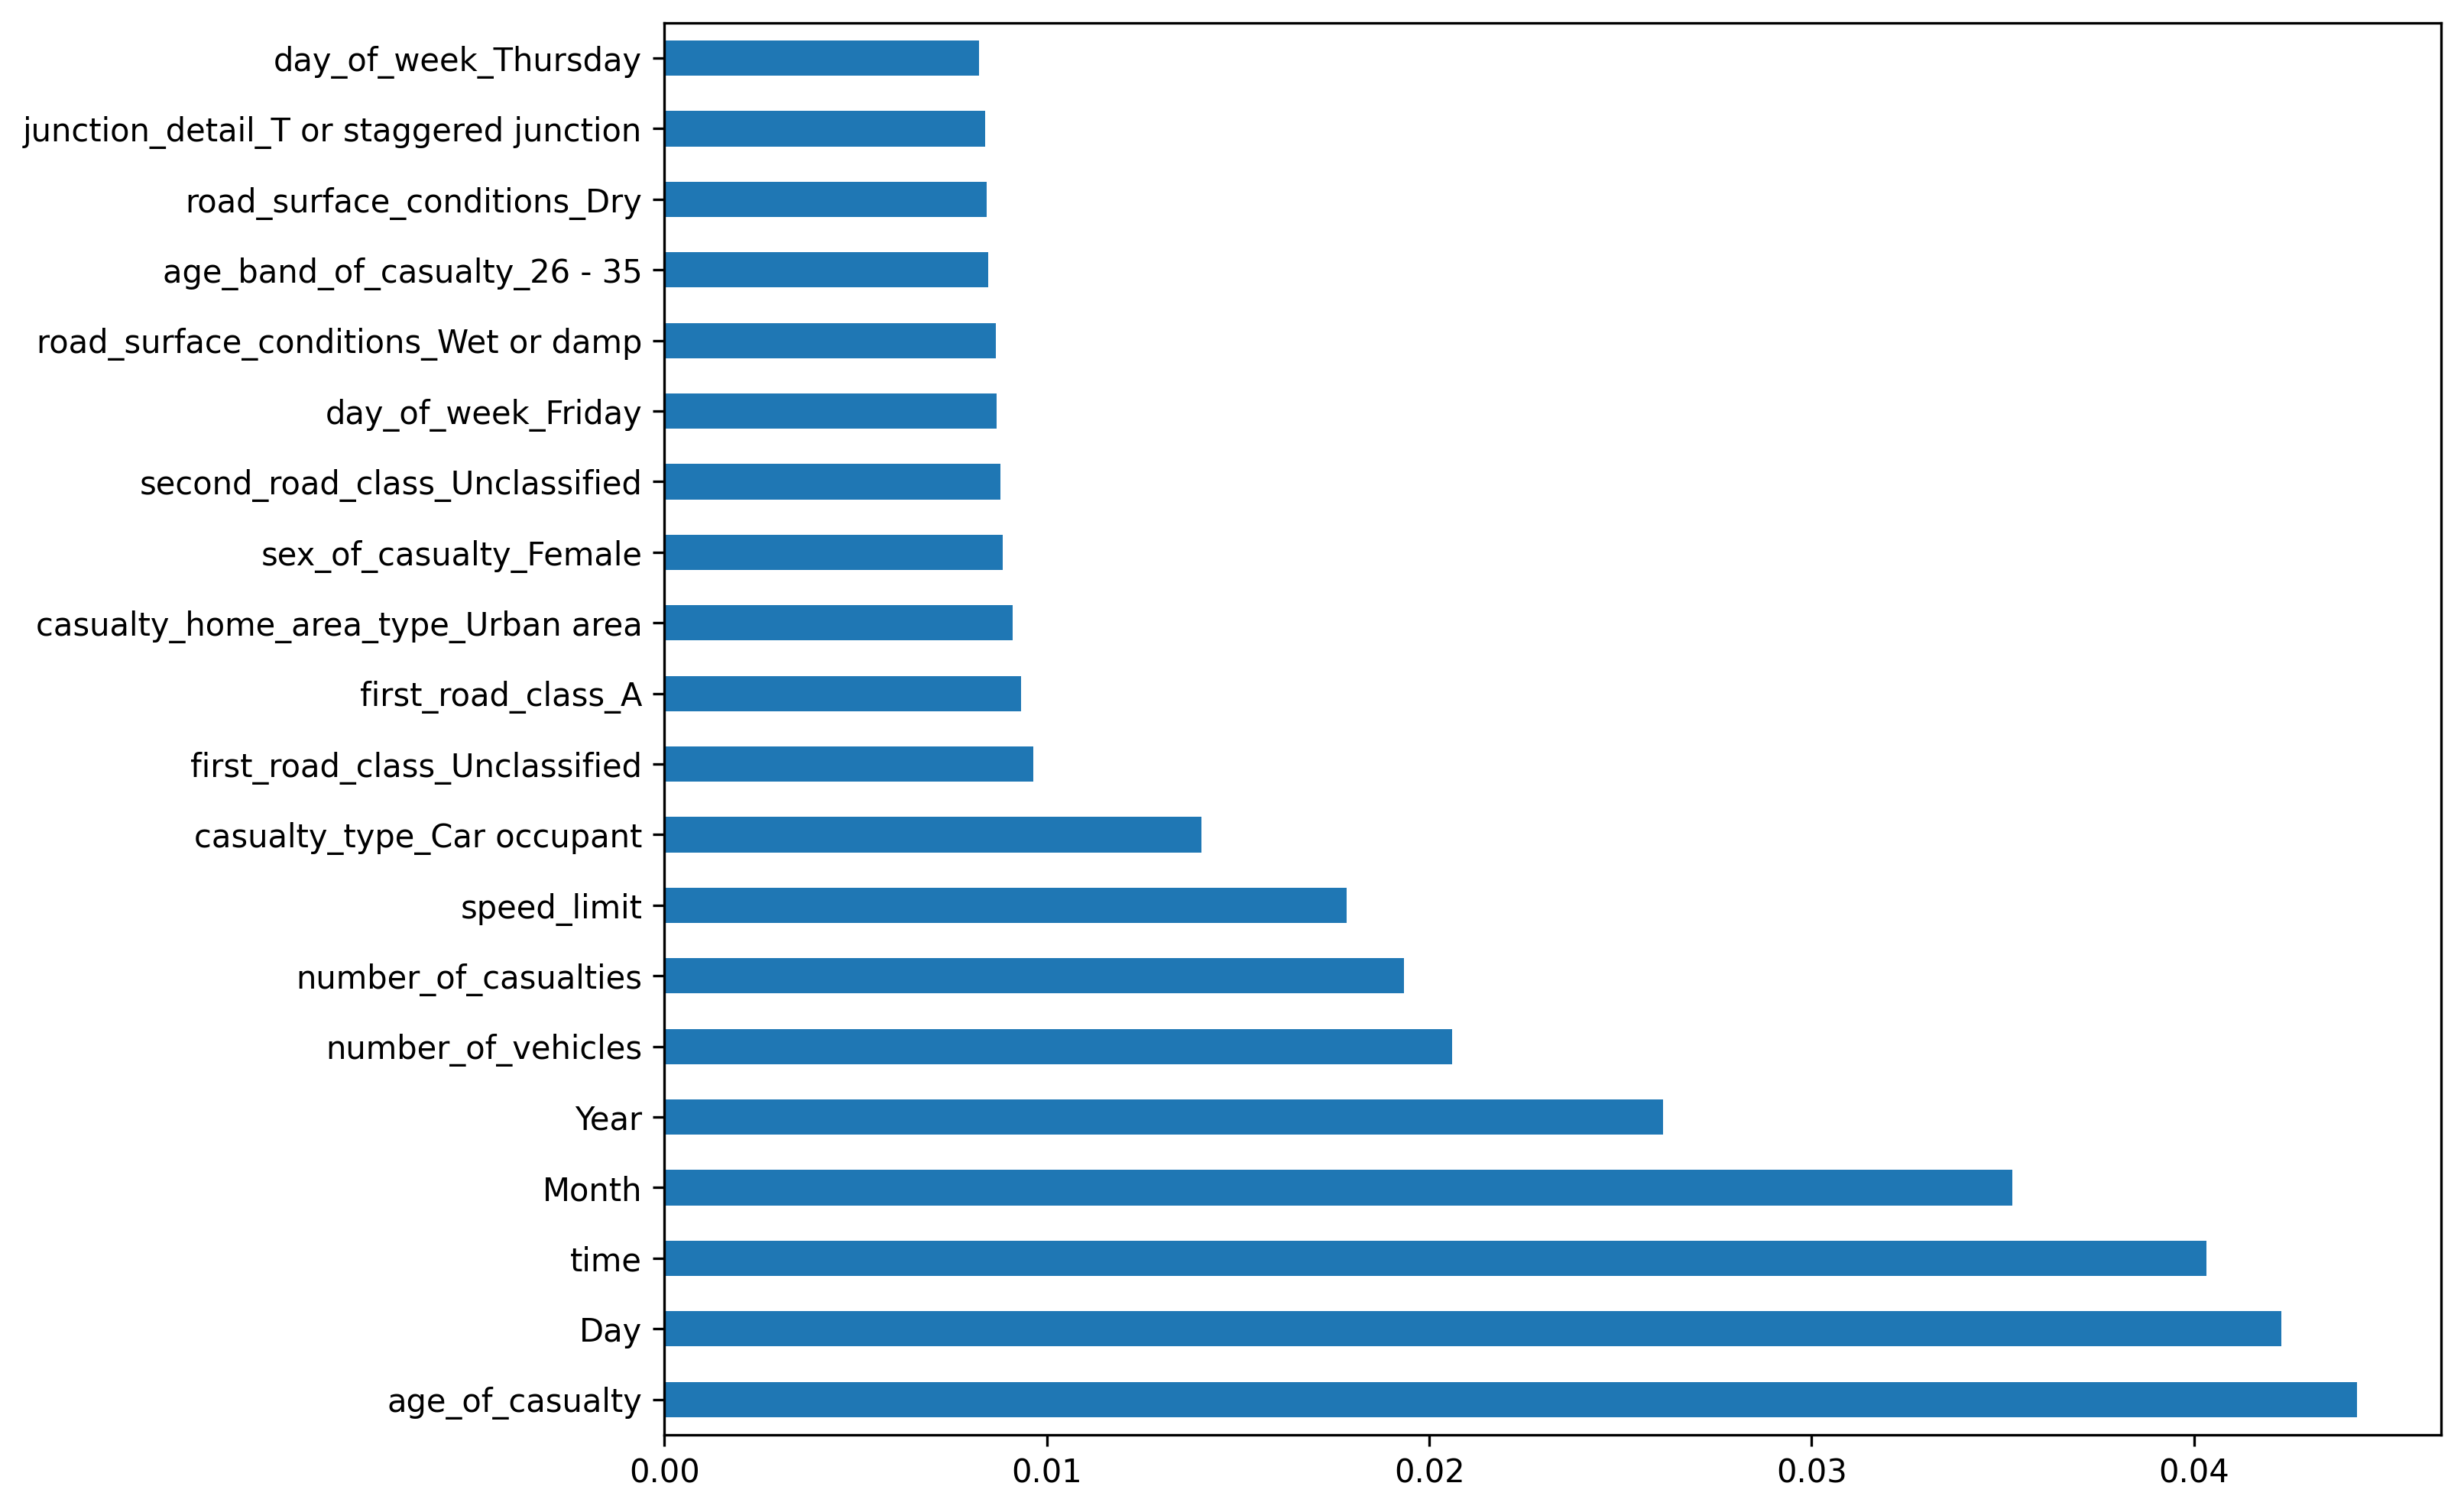

In [7]:
plt.figure(figsize=(10,8), dpi=300, facecolor='w', edgecolor='k')

feat_importances = pd.Series(clf.feature_importances_, index= X_train.columns)

feat_importances.nlargest(20).plot(kind='barh')

From our EDA, there are no dramatic surprises here. Year, Month, and Day are all coming up as some of the most important predictors - it is quite likely that the algorithm is 'learning' the crashes and memorising the dates due to the duplication of event dates for multi-casualty incidents. It is probably best that we remove these features to prevent this.

Let's have a quick peek at a Principle Components Analysis to check just how superfluous some of these features are..

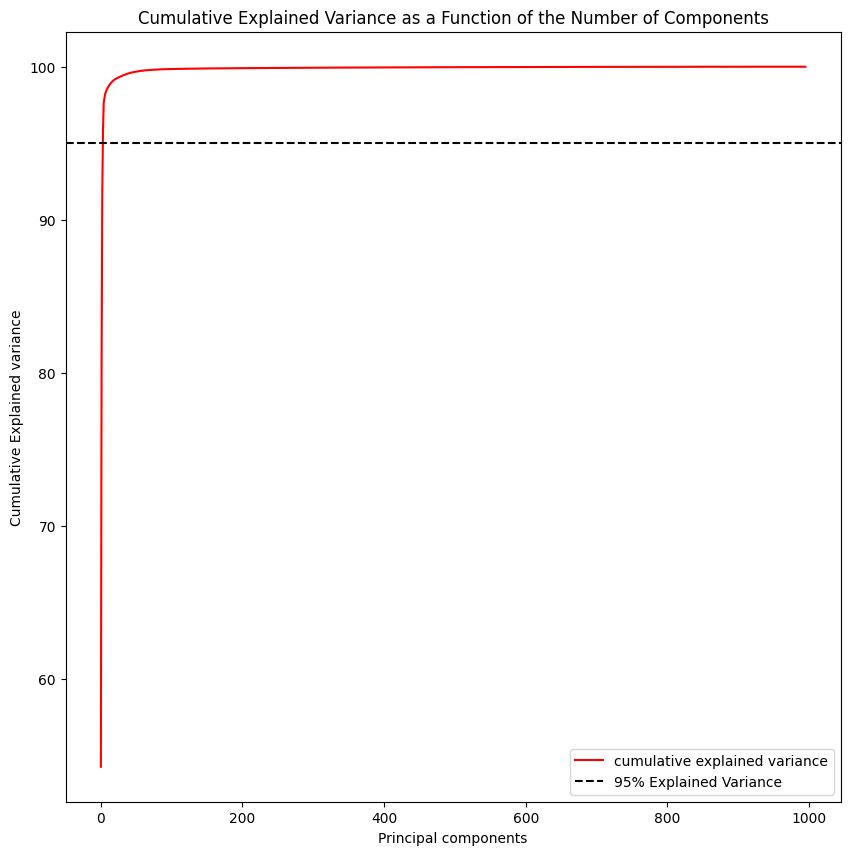

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(10, 10))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

Whew. Question answered - we have a huge amount of unnecessary features. It's likely that we will need to do a couple of rounds of feature engineering to cut down the bloat, and maybe use some clever Feature Selection techniques.


Without futher ado, let's forge onwards and trim down our feature set.